In [1]:
!pip install pycoingecko pytrends prophet sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import pandas as pd

def coin_price_hist(coin_id, vs_currency, days, interval):
    import pandas as pd
    import json
    from pycoingecko import CoinGeckoAPI
    cg = CoinGeckoAPI()

    df = cg.get_coin_market_chart_by_id(id=coin_id, vs_currency=vs_currency, days=days, interval=interval)
    x = json.dumps(df)
    y = pd.read_json(x)
    z = pd.DataFrame()
    z['market_tms'] = pd.to_datetime(pd.to_numeric(y.prices.str[0]), unit='ms')
    z['price'] = y.prices.str[1]
    z['mkt_cap'] = y.market_caps.str[1]
    z['total_volumes'] = y.market_caps.str[1]
    z = z.sort_values(by=['market_tms'], ascending=False)
    return (z)


def coin_candle_hist(coin_id, vs_currency, days):
    import pandas as pd
    import json
    from pycoingecko import CoinGeckoAPI
    cg = CoinGeckoAPI()
    df = cg.get_coin_ohlc_by_id(id=coin_id, vs_currency=vs_currency, days=days)
    x = json.dumps(df)
    y = pd.read_json(x)
    z = pd.DataFrame()
    z['market_tms'] = pd.to_datetime(y[0], unit='ms')
    z['open'] = y[1]
    z['high'] = y[2]
    z['low'] = y[3]
    z['close'] = y[4]
    z = z.sort_values(by=['market_tms'], ascending=False)
    return (z)


def get_binance_exchange_info():
    import pandas as pd
    from pycoingecko import CoinGeckoAPI
    cg = CoinGeckoAPI()

    binance_exchange = pd.DataFrame(columns=['base', 'target', 'market', 'last',
                                             'volume', 'converted_last', 'converted_volume',
                                             'trust_score', 'bid_ask_spread_percentage', 'timestamp',
                                             'last_traded_at', 'last_fetch_at', 'is_anomaly', 'is_stale',
                                             'trade_url', 'token_info_url', 'coin_id', 'target_coin_id'])

    for i in range(1, 11):
        df = cg.get_exchanges_tickers_by_id(id='binance', page=i, depth=True)
        page = pd.DataFrame(df['tickers'],
                            columns=['base', 'target', 'market', 'last',
                                     'volume', 'converted_last', 'converted_volume',
                                     'trust_score', 'bid_ask_spread_percentage', 'timestamp',
                                     'last_traded_at', 'last_fetch_at', 'is_anomaly', 'is_stale',
                                     'trade_url', 'token_info_url', 'coin_id', 'target_coin_id'])
        frames = [binance_exchange, page]

        binance_exchange = pd.concat(frames)
    return(binance_exchange)


def import_coin_list():
    import pandas as pd
    from pycoingecko import CoinGeckoAPI
    cg = CoinGeckoAPI()
    df = cg.get_coins_markets('usd')
    coin_list = pd.DataFrame(df, columns=['id', 'symbol', 'name'])
    coin_list['symbol'] = coin_list['symbol'].apply(lambda x: x.upper())
    return coin_list

def get_coin_hist_tms(coin):
	hist = pd.read_csv("data/" + coin +  "_btc.csv")
	hist = hist.iloc[::-1]
	return hist

def g_trend_pull(keywords):
	from pytrends.request import TrendReq
	pytrend = TrendReq()
	pytrend.build_payload(kw_list=keywords, timeframe='today 3-m')
	df = pytrend.interest_over_time()
	return df

### Indices for CoinGecko Price Search

In [2]:
index = import_coin_list()
index.head(10)

,id,symbol,name
0,bitcoin,BTC,Bitcoin
1,ethereum,ETH,Ethereum
2,tether,USDT,Tether
3,binancecoin,BNB,BNB
4,usd-coin,USDC,USD Coin
5,ripple,XRP,XRP
6,cardano,ADA,Cardano
7,staked-ether,STETH,Lido Staked Ether
8,dogecoin,DOGE,Dogecoin
9,matic-network,MATIC,Polygon


<Axes: title={'center': 'BTC / USD (Last 85 Days'}, xlabel='market_tms'>

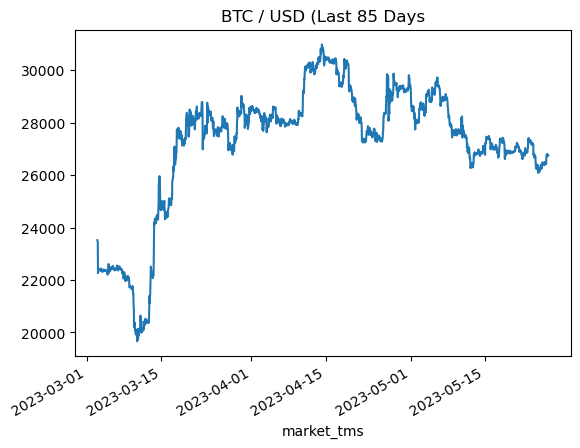

In [3]:
btc = coin_price_hist('bitcoin', 'usd', 85, 'hourly').sort_values(by='market_tms', ascending=True)
btc.set_index('market_tms').price.plot(title="BTC / USD (Last 85 Days")

In [4]:
btc.market_tms = btc.market_tms.dt.round('H')
btc = btc.set_index('market_tms')
btc.tail()

,price,mkt_cap,total_volumes
market_tms,,,
2023-05-26 19:00:00,26724.459026,5.183739e+11,5.183739e+11
2023-05-26 20:00:00,26791.219265,5.197663e+11,5.197663e+11
2023-05-26 21:00:00,26752.226589,5.190368e+11,5.190368e+11
2023-05-26 22:00:00,26737.244852,5.184365e+11,5.184365e+11
2023-05-26 23:00:00,26749.280422,5.185461e+11,5.185461e+11


In [5]:
btc_searches = g_trend_pull(['bitcoin'])
btc_searches.tail()

,bitcoin,isPartial
date,,
2023-05-18,57,False
2023-05-19,52,False
2023-05-20,45,False
2023-05-21,49,False
2023-05-22,53,False


<Axes: title={'center': 'BTC Google Search Score'}, xlabel='date'>

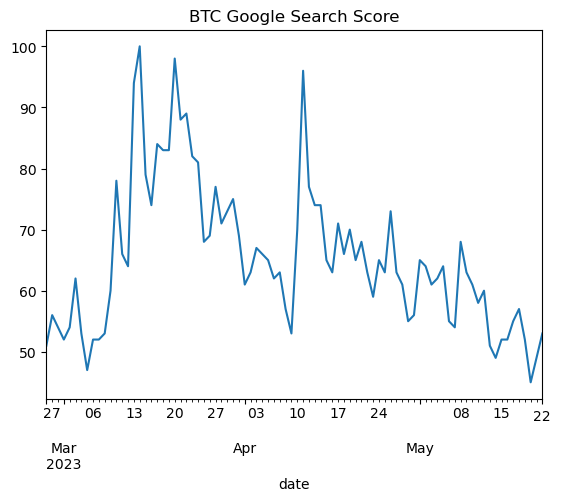

In [6]:
btc_searches.bitcoin.plot(title='BTC Google Search Score')

In [7]:
btc_searches['market_tms'] = btc_searches.index + pd.DateOffset(days=3)
btc_searches = btc_searches.set_index('market_tms')
btc_searches = btc_searches['bitcoin'].resample('H').ffill()
btc_searches = btc_searches.astype(float)
btc_searches

market_tms
2023-03-01 00:00:00    51.0
2023-03-01 01:00:00    51.0
2023-03-01 02:00:00    51.0
2023-03-01 03:00:00    51.0
2023-03-01 04:00:00    51.0
                       ... 
2023-05-24 20:00:00    49.0
2023-05-24 21:00:00    49.0
2023-05-24 22:00:00    49.0
2023-05-24 23:00:00    49.0
2023-05-25 00:00:00    53.0
Freq: H, Name: bitcoin, Length: 2041, dtype: float64

In [95]:
btc.price

market_tms
2023-03-02 23:00:00    23515.128732
2023-03-03 00:00:00    23469.231619
2023-03-03 01:00:00    23435.639295
2023-03-03 02:00:00    22259.675591
2023-03-03 03:00:00    22379.145940
                           ...     
2023-05-26 19:00:00    26724.459026
2023-05-26 20:00:00    26791.219265
2023-05-26 21:00:00    26752.226589
2023-05-26 22:00:00    26737.244852
2023-05-26 23:00:00    26749.280422
Name: price, Length: 2042, dtype: float64

In [28]:
gold

,Date,Price
0,2023-05-05 16:00:00,2016.37
1,2023-05-05 15:00:00,2018.10
2,2023-05-05 14:00:00,2016.68
3,2023-05-05 13:00:00,2015.57
4,2023-05-05 12:00:00,2017.23
...,...,...
26778,2019-01-01 21:00:00,1282.75
26779,2019-01-01 20:00:00,1279.89
26780,2019-01-01 19:00:00,1280.17
26781,2019-01-01 18:00:00,1281.29


In [101]:
gold = pd.read_excel('Gold_historical_data.xlsx')
gold['Date'] = pd.to_datetime(gold['Date'])
gold = gold.rename(columns={'Date':'market_tms', 'Price':'gold_price'})
#gold.set_index('ds', inplace=True)  

silver = pd.read_excel('Silver_historical_data.xlsx')
silver['Date'] = pd.to_datetime(silver['Date'])
silver = silver.rename(columns={'Date':'market_tms', 'Price':'silver_price'})
#silver.set_index('ds', inplace=True)  
silver

,market_tms,silver_price
0,2023-05-05 16:00:00,25.6623
1,2023-05-05 15:00:00,25.6595
2,2023-05-05 14:00:00,25.6443
3,2023-05-05 13:00:00,25.6001
4,2023-05-05 12:00:00,25.6355
...,...,...
26809,2019-01-01 13:00:00,15.5100
26810,2019-01-01 12:00:00,15.5100
26811,2019-01-01 07:00:00,15.5100
26812,2019-01-01 03:00:00,15.5105


In [94]:
prices = pd.merge(btc.price, btc_searches, how='inner', on='market_tms')
#prices = pd.merge(prices, gold, how='inner', on='market_tms')
#prices = pd.merge(prices, silver, how='inner', on='market_tms')
prices = prices.reset_index().rename(columns={'market_tms':'ds', 'price':'btc_usd', 'bitcoin':'btc_src','Price_x':'gold_price',\
                                                       'Price_y':'silver_price'})
prices

,ds,btc_usd,btc_src
0,2023-03-02 23:00:00,23515.128732,56.0
1,2023-03-03 00:00:00,23469.231619,54.0
2,2023-03-03 01:00:00,23435.639295,54.0
3,2023-03-03 02:00:00,22259.675591,54.0
4,2023-03-03 03:00:00,22379.145940,54.0
...,...,...,...
1990,2023-05-24 20:00:00,26276.319771,49.0
1991,2023-05-24 21:00:00,26404.486519,49.0
1992,2023-05-24 22:00:00,26365.125463,49.0
1993,2023-05-24 23:00:00,26340.456307,49.0


In [125]:
prices = pd.merge(btc.price, btc_searches, how='inner', on='market_tms')
prices = prices.join(gold.set_index('market_tms'), on='market_tms')
prices = prices.join(silver.set_index('market_tms'), on='market_tms')

# Interpolate missing values
prices['gold_price'] = prices['gold_price'].interpolate()
prices['silver_price'] = prices['silver_price'].interpolate()

prices = prices.reset_index().rename(columns={'market_tms':'ds', 'price':'btc_usd', 'bitcoin':'btc_src','Price_x':'gold_price',\
                                               'Price_y':'silver_price'})
prices


,ds,btc_usd,btc_src,gold_price,silver_price
0,2023-03-02 23:00:00,23515.128732,56.0,1838.52,20.9867
1,2023-03-03 00:00:00,23469.231619,54.0,1839.07,20.9769
2,2023-03-03 01:00:00,23435.639295,54.0,1843.13,21.0547
3,2023-03-03 02:00:00,22259.675591,54.0,1842.85,21.0249
4,2023-03-03 03:00:00,22379.145940,54.0,1844.31,21.0245
...,...,...,...,...,...
1990,2023-05-24 20:00:00,26276.319771,49.0,2016.37,25.6623
1991,2023-05-24 21:00:00,26404.486519,49.0,2016.37,25.6623
1992,2023-05-24 22:00:00,26365.125463,49.0,2016.37,25.6623
1993,2023-05-24 23:00:00,26340.456307,49.0,2016.37,25.6623


In [126]:
from sktime.forecasting.all import temporal_train_test_split
y_train, y_test = temporal_train_test_split(prices[['ds', 'btc_usd', 'btc_src','gold_price','silver_price']].set_index('ds'))
y_train = y_train.reset_index()[['ds', 'btc_usd', 'btc_src','gold_price','silver_price']].rename(columns={'btc_usd':'y'})
y_test = y_test.reset_index()[['ds', 'btc_usd', 'btc_src','gold_price','silver_price']].rename(columns={'btc_usd':'y'})

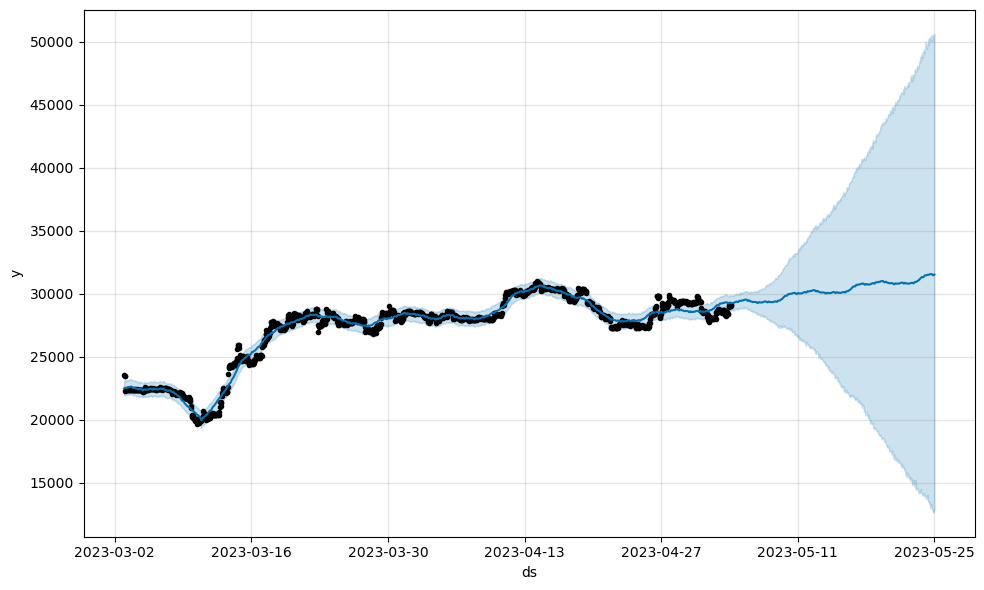

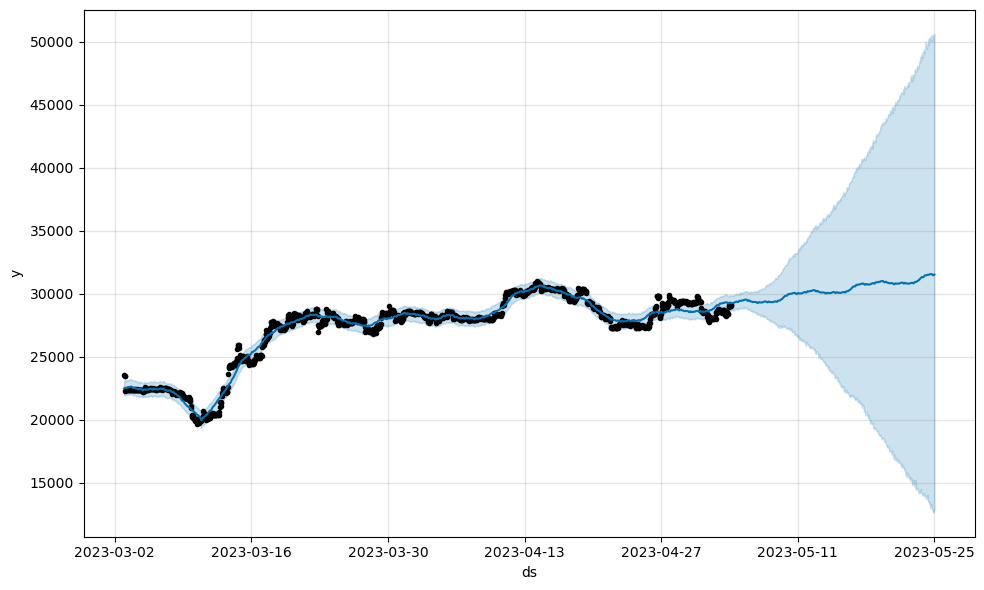

In [128]:
from prophet import Prophet 

m = Prophet()
m.add_regressor('btc_src')
m.fit(y_train[['ds', 'y', 'btc_src']])
future = m.make_future_dataframe(periods=len(y_test), freq='H')
future
future['btc_src'] = prices['btc_src']
future
forecast = m.predict(future)
m.plot(forecast)

In [129]:
f = forecast[forecast.ds >= y_test.ds.min()][['ds', 'yhat']]
y_pred = f.set_index('ds').yhat
y_pred

ds
2023-05-04 06:00:00    29259.522542
2023-05-04 07:00:00    29260.954160
2023-05-04 08:00:00    29253.388645
2023-05-04 09:00:00    29247.736912
2023-05-04 10:00:00    29254.733125
                           ...     
2023-05-24 20:00:00    31472.320987
2023-05-24 21:00:00    31454.651108
2023-05-24 22:00:00    31463.716586
2023-05-24 23:00:00    31490.067548
2023-05-25 00:00:00    31511.604114
Name: yhat, Length: 499, dtype: float64

In [130]:
y_test = y_test.set_index('ds').y
y_test

ds
2023-05-04 06:00:00    29200.318581
2023-05-04 07:00:00    29176.598226
2023-05-04 08:00:00    29078.472181
2023-05-04 09:00:00    29087.861031
2023-05-04 10:00:00    29069.403634
                           ...     
2023-05-24 20:00:00    26276.319771
2023-05-24 21:00:00    26404.486519
2023-05-24 22:00:00    26365.125463
2023-05-24 23:00:00    26340.456307
2023-05-25 00:00:00    26338.948947
Name: y, Length: 499, dtype: float64

In [131]:
filtered_s1 = y_pred.loc[y_pred.index.intersection(y_test.index)]
filtered_s2 = y_test.loc[y_test.index.intersection(y_pred.index)]
y_pred = filtered_s1
y_test = filtered_s2

<Axes: title={'center': 'BTC (Prophet) Outlook 30d Out'}>

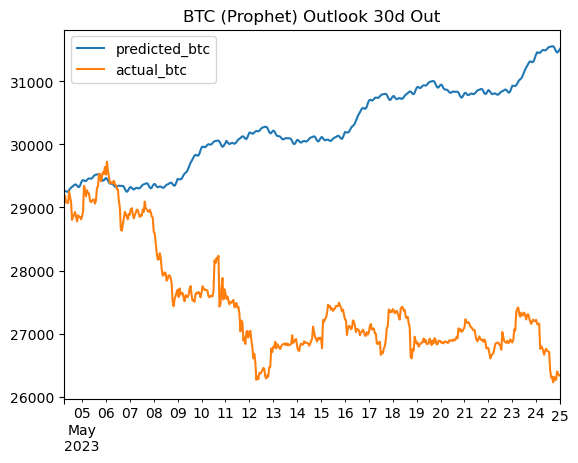

In [132]:
perf = pd.merge(y_pred, y_test, how='inner', on='ds').rename(columns={'yhat':'predicted_btc', 'y':'actual_btc'}).reset_index()
perf.set_index('ds').plot(title='BTC (Prophet) Outlook 30d Out', xlabel="")

In [134]:
prices

,ds,btc_usd,btc_src,gold_price,silver_price
0,2023-03-02 23:00:00,23515.128732,56.0,1838.52,20.9867
1,2023-03-03 00:00:00,23469.231619,54.0,1839.07,20.9769
2,2023-03-03 01:00:00,23435.639295,54.0,1843.13,21.0547
3,2023-03-03 02:00:00,22259.675591,54.0,1842.85,21.0249
4,2023-03-03 03:00:00,22379.145940,54.0,1844.31,21.0245
...,...,...,...,...,...
1990,2023-05-24 20:00:00,26276.319771,49.0,2016.37,25.6623
1991,2023-05-24 21:00:00,26404.486519,49.0,2016.37,25.6623
1992,2023-05-24 22:00:00,26365.125463,49.0,2016.37,25.6623
1993,2023-05-24 23:00:00,26340.456307,49.0,2016.37,25.6623


In [148]:
from tqdm import tqdm
import warnings
import logging

# Suppress annoying harmless warning
warnings.filterwarnings("ignore")
logging.getLogger('py4j').setLevel(logging.ERROR)

def build_prophet_model(prices, regressors=[], lookback_days=0.4):
    df = prices.tail(int(lookback_days*24))
    df = df.rename(columns={'btc_usd': 'y'})

    model = Prophet()

    if len(regressors) > 0:
        [model.add_regressor(x) for x in regressors]

    features = ['ds', 'y'] + regressors
    print(features)
    model.fit(df[features])
    
    future = model.make_future_dataframe(periods=1, freq='H')
    
    if len(regressors) == 1:    
        future[regressors[0]] = df.sort_values(by='ds', ascending=True).reset_index()[regressors[0]]
        future[regressors[0]] = future[regressors[0]].fillna(method = 'ffill')
    elif len(regressors) > 1:
        future[regressors] = df.sort_values(by='ds', ascending=True).reset_index()[regressors]
        future[regressors] = future[regressors].fillna(method = 'ffill')
    
    forecast = model.predict(future)
    
    return forecast['yhat'].iloc[-1]

def evaluate_model_over_time(prices, regressors=[], lookback=0.4):  
    df = prices.copy() 
    results = pd.DataFrame(columns=['ds', 'actual', 'predicted'])
    n_hours = len(df)
    
    lookback_hours = int(lookback*24)
    
    for i in tqdm(range(lookback_hours, n_hours), desc='Processing data'):
        actual_price = df.iloc[i]['btc_usd']
        actual_timestamp = df.iloc[i]['ds']
        window_prices = df.iloc[i-lookback_hours:i]
        predicted_price = build_prophet_model(window_prices, regressors, lookback)
        results = results.append({'ds': actual_timestamp, 'actual': actual_price, 'predicted': predicted_price}, ignore_index=True)

    results['sq_residual'] = (results['predicted'] - results['actual'])**2
    results['guidance'] = results['predicted'].shift(-1)
    results['actual_result'] = results['actual'].shift(-1)

    results['pnl'] = 0.0

    buy_mask = results['guidance'] > results['actual']
    results.loc[buy_mask, 'pnl'] = results.loc[buy_mask, 'actual_result'] - results.loc[buy_mask, 'actual']

    sell_mask = results['guidance'] < results['actual']
    results.loc[sell_mask, 'pnl'] = results.loc[sell_mask, 'actual'] - results.loc[sell_mask, 'actual_result']
    results['pnl_td'] = results['pnl'].cumsum()
    results['hold_value'] = results['actual'] - results['actual'].loc[0]
    
    return results

In [136]:
import logging
logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)
logging.getLogger('prophet').setLevel(logging.CRITICAL)

Processing data: 100%|████████████████████████| 327/327 [00:23<00:00, 13.94it/s]


<Axes: title={'center': 'Trading P&L Over Time (Solo Model)'}, xlabel='ds'>

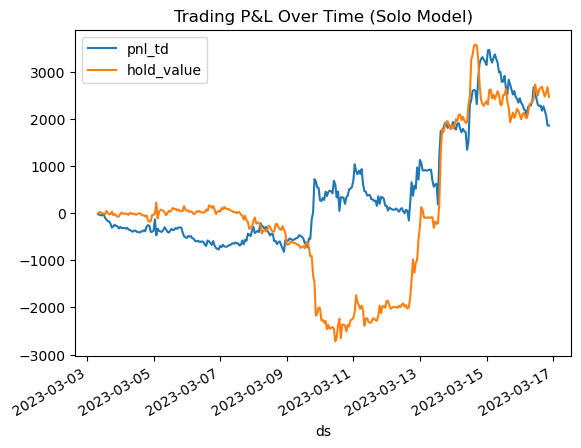

In [137]:
results = evaluate_model_over_time(prices[0:(7*24)+7*24])
results.set_index('ds')[['pnl_td','hold_value']].plot(title='Trading P&L Over Time (Solo Prophet Model)')

Processing data: 100%|████████████████████████| 327/327 [00:29<00:00, 11.09it/s]


<Axes: title={'center': 'Trading P&L Over Time (Prophet: regressor - Google Data Integration)'}, xlabel='ds'>

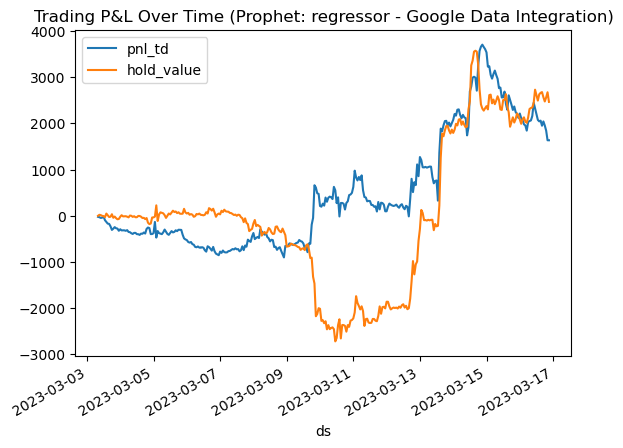

In [138]:
# Test Ru
results2 = evaluate_model_over_time(prices[0:(7*24)+7*24], regressors=['btc_src'])
results2.set_index('ds')[['pnl_td','hold_value']]\
                        .plot(title='Trading P&L Over Time (Prophet: regressor - Google Seacrhes Data )')

Processing data: 100%|████████████████████████| 327/327 [00:52<00:00,  6.24it/s]


<Axes: title={'center': 'Trading P&L Over Time (Prophet: regressor - Gold prices)'}, xlabel='ds'>

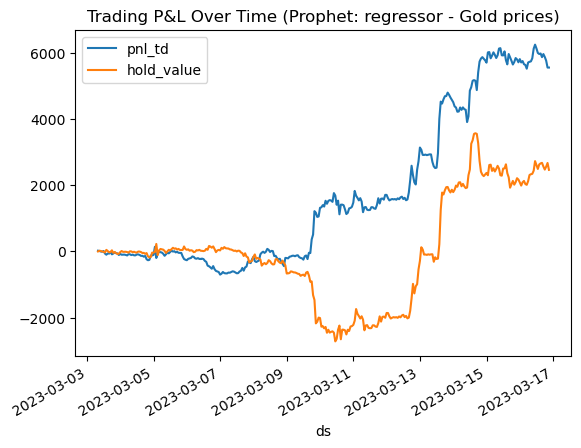

In [157]:
# Test Ru
results3 = evaluate_model_over_time(prices[0:(7*24)+7*24], regressors=['gold_price'])
results3.set_index('ds')[['pnl_td','hold_value']]\
                        .plot(title='Trading P&L Over Time (Prophet: regressor - Gold prices)')

Processing data: 100%|████████████████████████| 327/327 [00:50<00:00,  6.41it/s]


<Axes: title={'center': 'Trading P&L Over Time (Prophet: regressor - Silver prices)'}, xlabel='ds'>

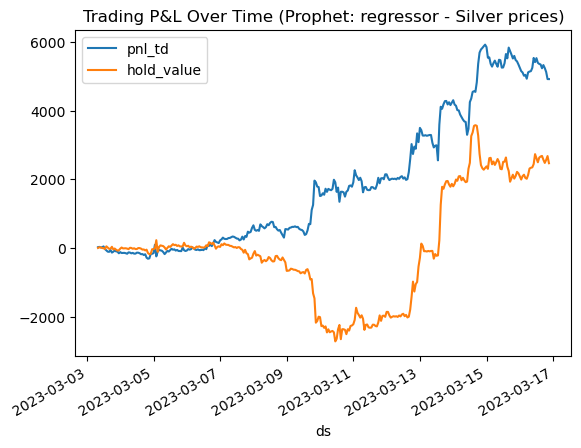

In [158]:
# Test Ru
results4 = evaluate_model_over_time(prices[0:(7*24)+7*24], regressors=['silver_price'])
results4.set_index('ds')[['pnl_td','hold_value']]\
                        .plot(title='Trading P&L Over Time (Prophet: regressor - Silver prices)')

Processing data: 100%|████████████████████████| 327/327 [05:15<00:00,  1.04it/s]


<Axes: title={'center': 'Trading P&L Over Time (Prophet with all three regressors)'}, xlabel='ds'>

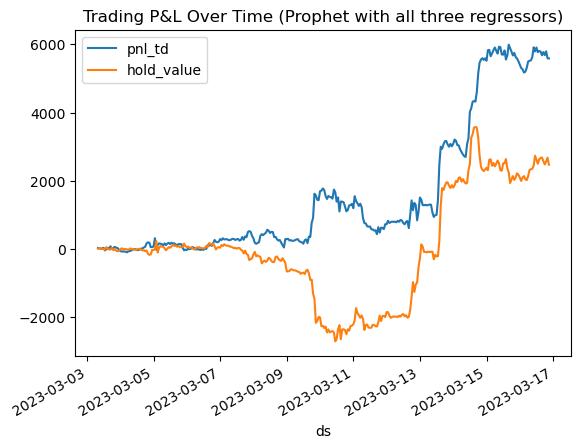

In [159]:
# Test Ru
results5 = evaluate_model_over_time(prices[0:(7*24)+7*24], regressors=['btc_src','gold_price','silver_price'])
results5.set_index('ds')[['pnl_td','hold_value']]\
                        .plot(title='Trading P&L Over Time (Prophet with all three regressors)')

<Axes: xlabel='pnl', ylabel='Density'>

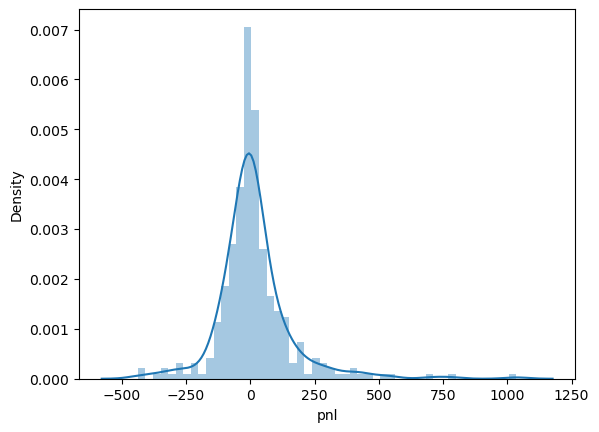

In [180]:
import seaborn as sns
sns.distplot(results2.pnl)

In [161]:
residuals

,ds,Solo Model (Half day),+Google Model (Half day),Gold Regressor (Half day),Silver Regressor (Half day),All 3 Regressors (Half day)
0,2023-03-03 08:00:00,94.112695,190.935893,159.481494,190.935893,27.745705
1,2023-03-03 09:00:00,109.981888,196.446831,168.992236,196.446831,78.108403
2,2023-03-03 10:00:00,111.005316,196.629262,169.359133,196.629262,80.230933
3,2023-03-03 11:00:00,114.169159,197.516558,170.175357,197.516558,82.445690
4,2023-03-03 12:00:00,114.257869,200.387304,170.669373,200.387304,82.674917
...,...,...,...,...,...,...
322,2023-03-16 17:00:00,3225.547268,10172.375100,10169.020794,10172.375100,9494.270901
323,2023-03-16 18:00:00,3226.279592,10172.650314,10169.028770,10172.650314,9494.280809
324,2023-03-16 19:00:00,3232.000592,10174.588795,10170.985339,10174.588795,9496.346686
325,2023-03-16 20:00:00,3235.670128,10175.921774,10176.133434,10175.921774,9496.865954


<Axes: title={'center': 'Sqrt of Cummulative SQ Errors'}, xlabel='ds'>

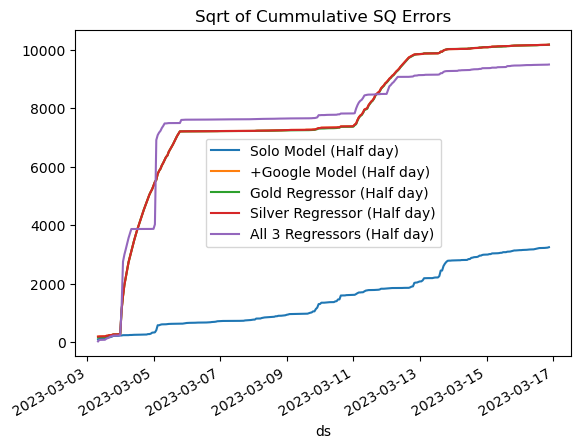

In [160]:
import math 

residuals = pd.DataFrame()
residuals['ds'] = results.ds
residuals['Solo Model (Half day)'] = results['sq_residual'].cumsum().apply(lambda x: math.sqrt(x))
residuals['+Google Model (Half day)'] =  results2['sq_residual'].cumsum().apply(lambda x: math.sqrt(x))
residuals['Gold Regressor (Half day)'] = results3['sq_residual'].cumsum().apply(lambda x: math.sqrt(x))
residuals['Silver Regressor (Half day)'] = results4['sq_residual'].cumsum().apply(lambda x: math.sqrt(x))
residuals['All 3 Regressors (Half day)'] = results5['sq_residual'].cumsum().apply(lambda x: math.sqrt(x))
residuals.set_index('ds').plot(title='Sqrt of Cummulative SQ Errors')

<Axes: xlabel='ds'>

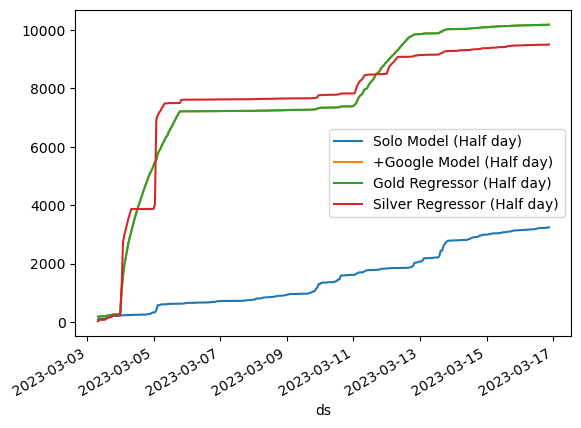

In [155]:
residuals.set_index('ds').plot()

In [ ]:
results4.to_csv('Best_+Google_Model_Perf.csv')

In [165]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots with a 2x2 grid
fig = make_subplots(rows=2, cols=2, subplot_titles=(
    '(Solo Model)',
    '(Regressor - Google Searches Data)',
    '(Regressor - Silver Prices)',
    '(Prophet with all three regressors)'
))

# Plot 1: Solo Prophet Model
fig.add_trace(go.Scatter(x=results['ds'], y=results['pnl_td'], name='P&L TD'), row=1, col=1)
fig.add_trace(go.Scatter(x=results['ds'], y=results['hold_value'], name='Hold Value'), row=1, col=1)

# Plot 2: Prophet with regressor - Google Searches Data
fig.add_trace(go.Scatter(x=results2['ds'], y=results2['pnl_td'], name='P&L TD'), row=1, col=2)
fig.add_trace(go.Scatter(x=results2['ds'], y=results2['hold_value'], name='Hold Value'), row=1, col=2)

# Plot 3: Prophet with regressor - Silver Prices
fig.add_trace(go.Scatter(x=results3['ds'], y=results3['pnl_td'], name='P&L TD'), row=2, col=1)
fig.add_trace(go.Scatter(x=results3['ds'], y=results3['hold_value'], name='Hold Value'), row=2, col=1)

# Plot 4: Prophet with all three regressors
fig.add_trace(go.Scatter(x=results4['ds'], y=results4['pnl_td'], name='P&L TD'), row=2, col=2)
fig.add_trace(go.Scatter(x=results4['ds'], y=results4['hold_value'], name='Hold Value'), row=2, col=2)

# Update layout
fig.update_layout(height=600, width=800, title_text='Trading P&L Over Time (Prophet Models)')

# Show the plot
fig.show()


In [182]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define a color palette
colors = ['blue', 'orange']

# Create subplots with a 2x3 grid
fig = make_subplots(rows=2, cols=2, subplot_titles=(
    '(Solo Model)',
    '(Regressor - Google Searches Data)',
    '(Regressor - Gold Prices)',
    '(Regressor - Silver Prices)',
))

# Plot 1: Solo Prophet Model
fig.add_trace(go.Scatter(x=results['ds'], y=results['pnl_td'], name='P&L TD', line_color=colors[0], showlegend=True), row=1, col=1)
fig.add_trace(go.Scatter(x=results['ds'], y=results['hold_value'], name='Hold Value', line_color=colors[1], showlegend=True), row=1, col=1)

# Plot 2: Prophet with regressor - Google Searches Data
fig.add_trace(go.Scatter(x=results2['ds'], y=results2['pnl_td'], name='P&L TD', line_color=colors[0], showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=results2['ds'], y=results2['hold_value'], name='Hold Value', line_color=colors[1], showlegend=False), row=1, col=2)

# Plot 3: Prophet with regressor - Silver Prices
fig.add_trace(go.Scatter(x=results3['ds'], y=results3['pnl_td'], name='P&L TD', line_color=colors[0], showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=results3['ds'], y=results3['hold_value'], name='Hold Value', line_color=colors[1], showlegend=False), row=2, col=1)

# Plot 4: Prophet with all three regressors
fig.add_trace(go.Scatter(x=results4['ds'], y=results4['pnl_td'], name='P&L TD', line_color=colors[0], showlegend=False), row=2, col=2)
fig.add_trace(go.Scatter(x=results4['ds'], y=results4['hold_value'], name='Hold Value', line_color=colors[1], showlegend=False), row=2, col=2)

# Update layout
fig.update_layout(height=900, width=900, title_text='Trading P&L Over Time (Prophet Models)')

# Show the plot
fig.show()


<Axes: title={'center': 'Trading P&L Over Time (Prophet: regressor - Gold prices)'}, xlabel='ds'>

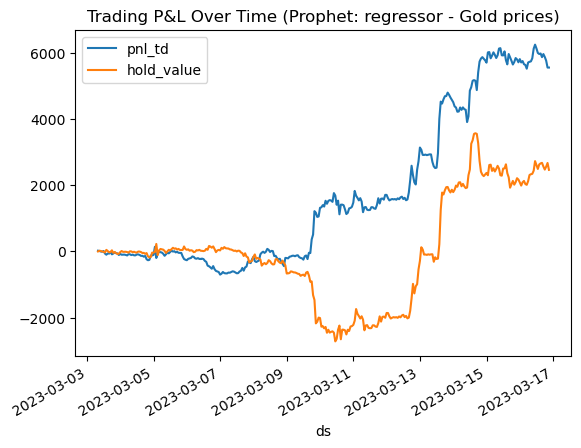

In [183]:
results3.set_index('ds')[['pnl_td','hold_value']]\
                        .plot(title='Trading P&L Over Time (Prophet: regressor - Gold prices)')